In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
housing_full = pd.read_csv('data/Housing_data.csv')

In [4]:
housing_full.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

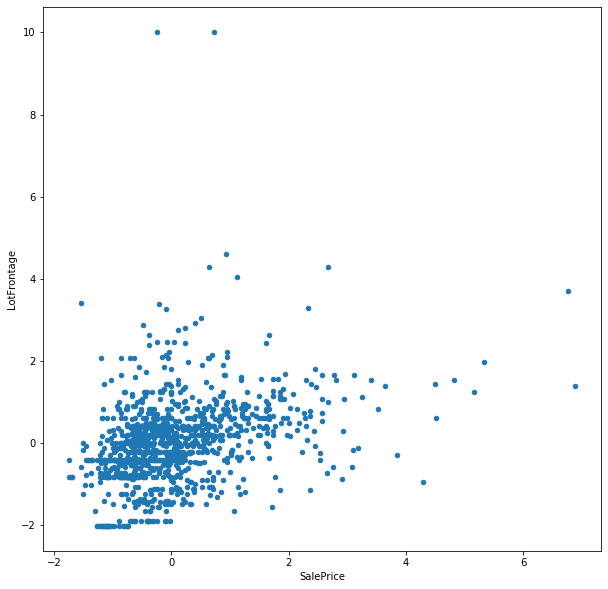

In [5]:
from sklearn.preprocessing import StandardScaler

df = housing_full[['SalePrice', 'LotFrontage']]
df = df.dropna()

cols = list(df.columns)

for column in cols:
    df[column] = StandardScaler().fit_transform(df[[column]])

# figure = plt.figure()
df.plot.scatter(x=cols[0], y=cols[1], figsize=(10,10))
# plt.scatter(x=df[cols[0]], y=df[cols[1]])

In [6]:
from sklearn.neighbors import LocalOutlierFactor

loc = LocalOutlierFactor(n_neighbors=10)

In [7]:
loc.fit(df)
df['LOF Score'] = loc.negative_outlier_factor_*(-1)
df['Outlier'] = loc.fit_predict(df)

In [8]:
df['LOF Score'].describe()

count    1201.000000
mean        1.130937
std         0.336821
min         0.867070
25%         0.996743
50%         1.037166
75%         1.135625
max         6.338480
Name: LOF Score, dtype: float64

In [9]:
df['color'] = ['blue']*len(df)

In [10]:
df['color'] = df['LOF Score'].map(lambda x: 'orange' if x>=1.5 else 'blue')

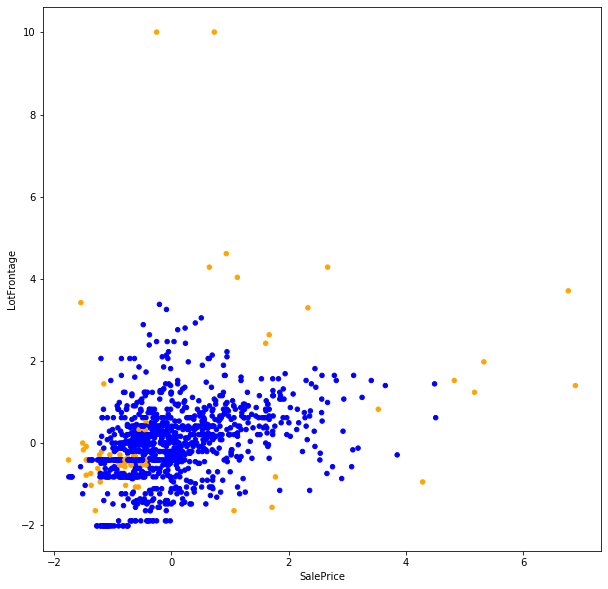

In [11]:
df.plot.scatter(x=cols[0], y=cols[1], c=df['color'],figsize=(10,10))

In [12]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity()
kde.fit(df[cols])

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

In [13]:
df['kde'] = kde.score_samples(df[cols])

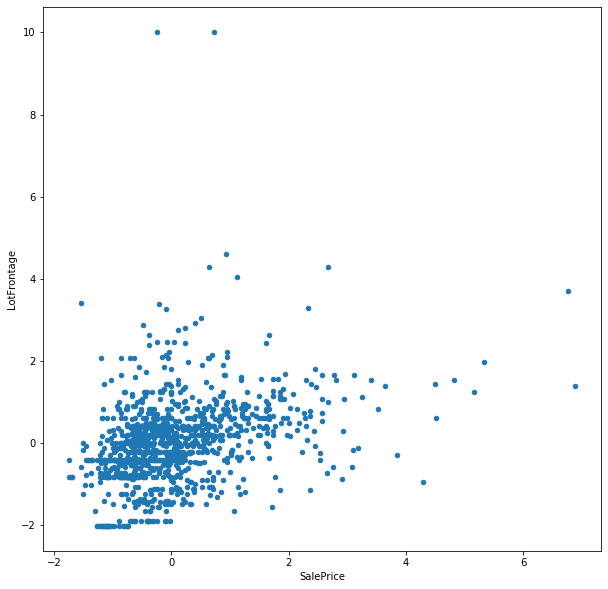

In [14]:
df.plot.scatter(x=cols[0], y=cols[1], figsize=(10,10))

In [15]:
from sklearn.neighbors import LocalOutlierFactor, KernelDensity, NearestNeighbors

def transform(df, cols=None):
    
    # preprocess (Done previously.)
    
    # Calculate metrics
    
    # 1. KDE 
    kde = KernelDensity()
    kde.fit(df[cols])
    
    # sklearn kde gives us log density. We have observed -ve values.
    
    df['kde'] = kde.score_samples(df[cols])
    
    # 2. LOF
    
    loc = LocalOutlierFactor()
    loc.fit(df[cols])
    
    # similar assumption as above (TODO better way to address) 
    df['LOF Score'] = loc.negative_outlier_factor_*(-1)
    df['Outlier'] = loc.fit_predict(df[cols])
    
    # Transform metric values (LOF, Density)
    
    # Calculate density peaks
    # Currently set them to top 10% highest kde density points
    # According to transformed metric, that would be 10th percentile
    
    threshold = np.percentile(df['kde'], 10)
    
    # Calculate all points with density field less than this value
    peaks = df[df['kde']<=threshold]
    peaks = peaks[cols].to_numpy()
    peaks_nn = NearestNeighbors(n_neighbors=1)
    peaks_nn.fit(peaks)
    
    # Nearest neigbor for each datapoint (TODO: parallelize)
    df['dens_X'] = [0]*len(df)
    df['dens_Y'] = [0]*len(df)
    df['dens_dist'] = [0]*len(df)
    df['X_new'] = [0]*len(df)
    df['Y_new'] = [0]*len(df)
    
    for i in tqdm(range(len(df))):
        
        distance, index = peaks_nn.kneighbors(df[cols].to_numpy())
        curr_peak = peaks[index[0][0],:]
        df['dens_X'].iloc[i] = curr_peak[0]
        df['dens_Y'].iloc[i] = curr_peak[1]
        df['dens_dist'].iloc[i] = distance[0][0]
        
        # Displacement vector multiplied by scale and transformed
        dx = curr_peak[0] - df[cols[0]].iloc[i]
        dy = curr_peak[1] - df[cols[1]].iloc[i]
        
#         scale = df['kde'].iloc[i]/(df['LOF Score'].iloc[i]*10*distance[0][0])
        scale = df['kde'].iloc[i]-df['LOF Score'].iloc[i]*10-distance[0][0]

        dx*=scale
        dy*=scale
        
        df['X_new'].iloc[i] = df[cols[0]].iloc[i]+dx
        df['Y_new'].iloc[i] = df[cols[1]].iloc[i]+dy
    
    return df

In [16]:
df = transform(df, cols)

100%|█████████████████████████████████████████████████████████████████████████████| 1201/1201 [00:08<00:00, 145.35it/s]


In [17]:
new_cols = ['X_new', 'Y_new']

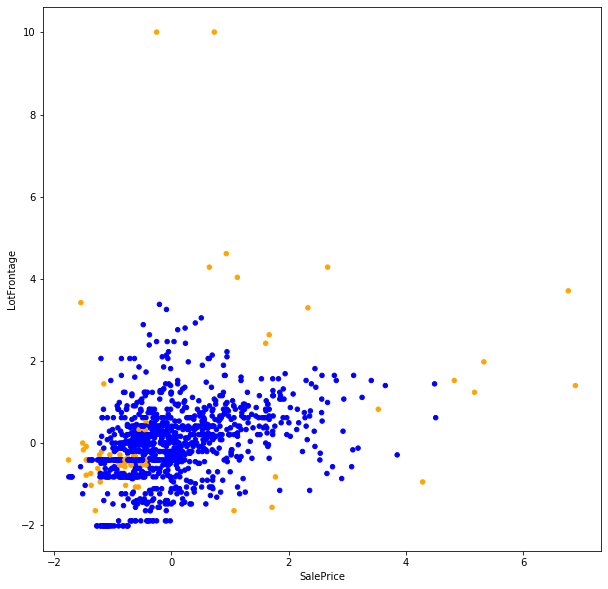

In [18]:
df.plot.scatter(x=cols[0], y=cols[1],c=df['color'], figsize=(10,10))

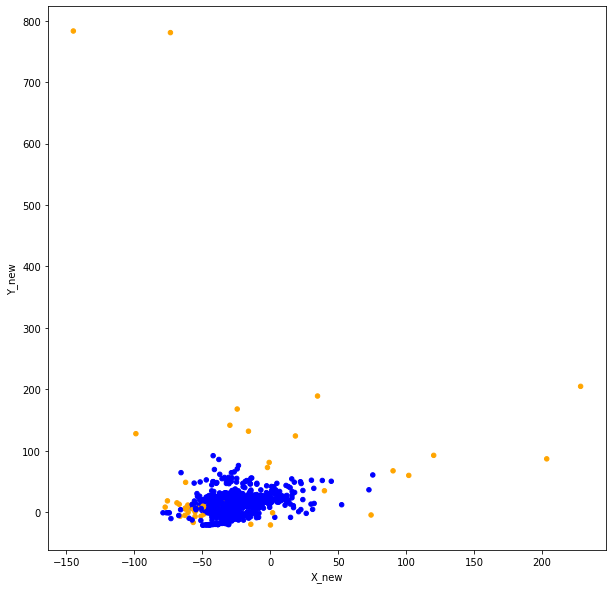

In [19]:
df.plot.scatter(x=new_cols[0], y=new_cols[1], c=df['color'],figsize=(10,10))